# Image Classification Model

## Imports

In [60]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import datetime

# Load data

In [61]:
labels = ['cocacola' , 'pepsi']
# desired image size
img_size = 96

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return data

In [62]:
train_path = 'images/train'
test_path = 'images/test'

train = get_data(train_path)
test = get_data(test_path)

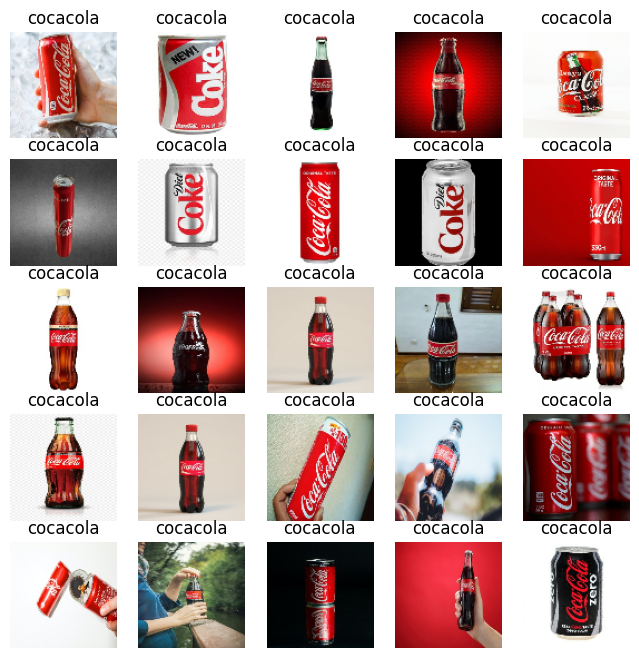

In [63]:
plt.figure(figsize = (8,8))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(train[i][0])
    plt.title(labels[train[i][1]])
    plt.axis("off")

# Data preprocessing and augmentation

## Split data

In [64]:
X_train = []
y_train = []
X_test = []
y_test = []

for feature, label in train:
  X_train.append(feature)
  y_train.append(label)

for feature, label in test:
  X_test.append(feature)
  y_test.append(label)

## Normalise data

In [65]:
# Normalise the data
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255

X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Augment data

In [22]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True, 
                             featurewise_std_normalization=False, 
                             rotation_range=20, 
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True
                            )


datagen.fit(X_train)
datagen.fit(X_test)

## Augmentation Example

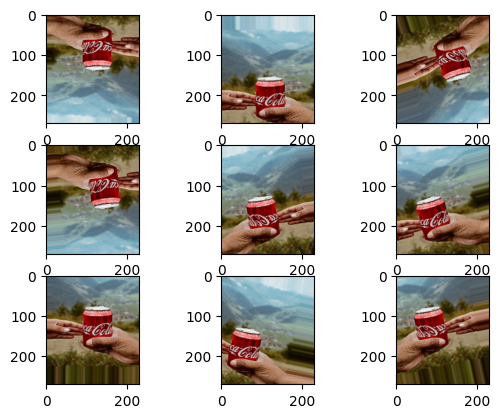

In [23]:
from tensorflow.keras.preprocessing.image import load_img , img_to_array
# load an image
img_ex = load_img('images/test/cocacola/8.jpg')
data_ex = img_to_array(img_ex)
# expand dimension to one sample
samples_ex = np.expand_dims(data_ex, 0)
# create image data augmentation generator
datagen_example = ImageDataGenerator(
                    featurewise_center=False,  # set input mean to 0 over the dataset
                    samplewise_center=False,  # set each sample mean to 0
                    featurewise_std_normalization=False,  # divide inputs by std of the dataset
                    samplewise_std_normalization=False,  # divide each input by its std
                    zca_whitening=False,  # apply ZCA whitening
                    rotation_range = 30,  # randomly rotate images in the range
                    horizontal_flip = True,  # randomly flip images
                    vertical_flip=False,    # randomly flip images
                    zoom_range=[0.5,1.0],    # zoom in and out the image
                    brightness_range=[0.5,1.5]
                    )
# prepare iterator
it = datagen.flow(samples_ex, batch_size=1)
# generate samples and plot
for i in range(9):
 # define subplot
 plt.subplot(330 + 1 + i)
 # generate batch of images
 batch = it.next()
 # convert to unsigned integers for viewing
 image = batch[0].astype('uint8')
 # plot raw pixel data
 plt.imshow(image)
# show the figure
plt.show()

# Define the model

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout

def training_model():
    model = Sequential(
        [
            Conv2D(filters=48, kernel_size=3, activation='relu', input_shape=[96, 96, 3]),
            MaxPool2D(pool_size=2, strides=2),
            Conv2D(filters=48, kernel_size=3, activation='relu'),
            MaxPool2D(pool_size=2, strides=2),
            Conv2D(filters=32, kernel_size=3, activation='relu'),
            MaxPool2D(pool_size=2, strides=2),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(2, activation='softmax')
        ]
    )
    return model

# Define the model
initial_model = training_model()

## Model summary

In [67]:
initial_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 48)        1344      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 48)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 48)        20784     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 48)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 32)        13856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 32)      

## Compile the model

In [68]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate=0.00001)
initial_model.compile(optimizer = opt,
                      loss = SparseCategoricalCrossentropy(from_logits=True),
                      metrics = ['accuracy']
                     )

##  Tensorboard

In [32]:
# Remove previous log data for tensorboard:
!rm -rf ./logs/
# Make new directory:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Define callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Launch:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


## Fit the model

In [73]:
EPOCHS = 100
history = initial_model.fit(x=X_train,
                            y=y_train,
                            epochs = EPOCHS,
                            validation_data = (X_test, y_test),
                            callbacks = [tensorboard_callback]
                          )

Epoch 1/100


/Users/francescomaraschin/Desktop/IC_Own_Model/venv/lib/python3.9/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-03-16 13:23:57.920656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.4971

2023-03-16 13:23:59.246548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 115ms/step - loss: 0.6935 - accuracy: 0.4971 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 2/100
11/11 [==============================] - 1s 69ms/step - loss: 0.6899 - accuracy: 0.4971 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 3/100
11/11 [==============================] - 1s 71ms/step - loss: 0.6867 - accuracy: 0.5000 - val_loss: 0.6869 - val_accuracy: 0.5000
Epoch 4/100
11/11 [==============================] - 1s 54ms/step - loss: 0.6840 - accuracy: 0.5382 - val_loss: 0.6845 - val_accuracy: 0.5333
Epoch 5/100
11/11 [==============================] - 1s 54ms/step - loss: 0.6811 - accuracy: 0.5706 - val_loss: 0.6817 - val_accuracy: 0.5833
Epoch 6/100
11/11 [==============================] - 1s 52ms/step - loss: 0.6777 - accuracy: 0.6176 - val_loss: 0.6779 - val_accuracy: 0.6333
Epoch 7/100
11/11 [==============================] - 1s 50ms/step - loss: 0.6737 - accuracy: 0.6500 - val_loss: 0.6734 - val_accuracy: 0.6500
Epoch 8/100
11/11

In [36]:
EPOCHS = 100
history = initial_model.fit(datagen.flow(X_train, y_train),
                            epochs = EPOCHS,
                            validation_data = datagen.flow(X_test, y_test),
                            callbacks = [tensorboard_callback]
                          )

Epoch 1/100
11/11 [==============================] - 1s 88ms/step - loss: 0.2349 - accuracy: 0.9147 - val_loss: 0.2057 - val_accuracy: 0.9500
Epoch 2/100
11/11 [==============================] - 1s 69ms/step - loss: 0.2163 - accuracy: 0.9059 - val_loss: 0.1856 - val_accuracy: 0.9333
Epoch 3/100
11/11 [==============================] - 1s 61ms/step - loss: 0.2241 - accuracy: 0.9000 - val_loss: 0.1524 - val_accuracy: 0.9667
Epoch 4/100
11/11 [==============================] - 1s 59ms/step - loss: 0.2275 - accuracy: 0.9088 - val_loss: 0.1672 - val_accuracy: 0.9500
Epoch 5/100
11/11 [==============================] - 1s 59ms/step - loss: 0.2300 - accuracy: 0.9059 - val_loss: 0.1914 - val_accuracy: 0.9333
Epoch 6/100
11/11 [==============================] - 1s 72ms/step - loss: 0.2115 - accuracy: 0.8912 - val_loss: 0.2161 - val_accuracy: 0.9500
Epoch 7/100
11/11 [==============================] - 1s 67ms/step - loss: 0.2171 - accuracy: 0.9118 - val_loss: 0.1767 - val_accuracy: 0.9333
Epoch 

## Evaluate the result

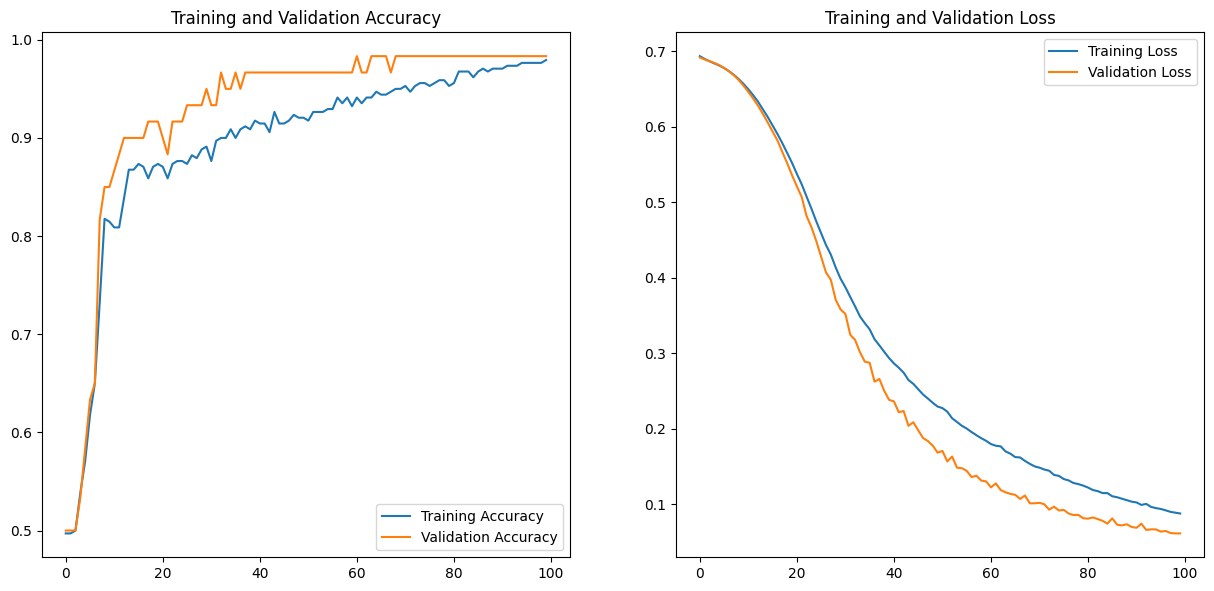

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Print F1 scores

In [75]:
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

predictions = initial_model.predict(X_test)
predictions=np.argmax(predictions,axis=1)
print(classification_report(y_test, predictions, target_names = ['Cocacola','Pepsi']))

2/2 [==============================] - 0s 78ms/step
              precision    recall  f1-score   support

    Cocacola       0.97      1.00      0.98        30
       Pepsi       1.00      0.97      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



2023-03-16 13:25:08.395602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Confusion matrix

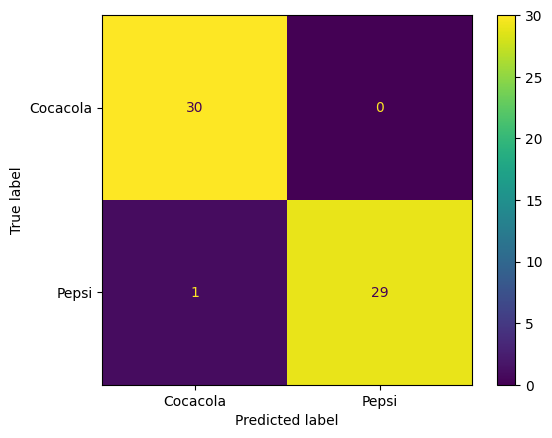

In [76]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Cocacola','Pepsi']
                             )
disp.plot()
plt.show()

## Save the model

In [77]:
h5Path = 'intial_model.h5'
initial_model.save(filepath=h5Path)

# PRUNING

## Load model

In [78]:
from tensorflow.keras.models import load_model
# Load the serialized model
loaded_model = load_model('intial_model.h5')

## Parameters

In [79]:
PRUNING_EPOCHS = 6
NUM_TRAIN_EXAMPLES = 340
BATCH_SIZE = 32
BEGIN_STEP = 0

END_STEP = np.ceil(1.0 * NUM_TRAIN_EXAMPLES / BATCH_SIZE).astype(np.int32) * EPOCHS
print("The end step is:",END_STEP)

The end step is: 1100


In [80]:
from tensorflow_model_optimization.sparsity.keras import ConstantSparsity

# The new pruning parameters are:
pruning_params = {
      'pruning_schedule': ConstantSparsity(target_sparsity=0.875,
                                           begin_step=0,
                                           end_step=END_STEP)
                 }

## New pruned model

In [81]:
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude

pruned_model = prune_low_magnitude(loaded_model, **pruning_params)

## Summary

In [82]:
pruned_model.summary()

# OBS: The new parameters came from the pruning wrappers and will be removed later

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d_  (None, 94, 94, 48)       2642      
 3 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 47, 47, 48)       1         
 ling2d_3 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_conv2d_  (None, 45, 45, 48)       41522     
 4 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 22, 22, 48)       1         
 ling2d_4 (PruneLowMagnitude                                     
 )                                                    

## Compile the model

In [83]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

opt = Adam()
pruned_model.compile( optimizer = opt,
                      loss = SparseCategoricalCrossentropy(),
                      metrics = ['accuracy']
                    )

## Pruning

In [84]:
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep
# Add a pruning step callback to peg the pruning step to the optimizer's
callbacks = [ UpdatePruningStep() ]

pruning_history = pruned_model.fit(X_train, y_train,
                                  batch_size=BATCH_SIZE,
                                  epochs=PRUNING_EPOCHS,
                                  verbose=1,
                                  callbacks=callbacks,
                                  validation_data=(X_test, y_test)
                                )

Epoch 1/6


2023-03-16 13:25:25.178431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 3s 90ms/step - loss: 1.2709 - accuracy: 0.6765 - val_loss: 0.4262 - val_accuracy: 0.9500
Epoch 2/6


2023-03-16 13:25:26.442541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 56ms/step - loss: 0.4072 - accuracy: 0.9000 - val_loss: 0.3037 - val_accuracy: 0.9500
Epoch 3/6
11/11 [==============================] - 1s 54ms/step - loss: 0.2678 - accuracy: 0.9529 - val_loss: 0.1098 - val_accuracy: 1.0000
Epoch 4/6
11/11 [==============================] - 1s 56ms/step - loss: 0.1160 - accuracy: 0.9618 - val_loss: 0.0422 - val_accuracy: 0.9833
Epoch 5/6
11/11 [==============================] - 1s 60ms/step - loss: 0.1040 - accuracy: 0.9735 - val_loss: 0.0531 - val_accuracy: 0.9667
Epoch 6/6
11/11 [==============================] - 1s 57ms/step - loss: 0.0783 - accuracy: 0.9735 - val_loss: 0.0342 - val_accuracy: 0.9833


## Evaluation

In [85]:
score = pruned_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03419281914830208
Test accuracy: 0.98333340883255


## Strip model of wrappers

In [86]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning

final_model = strip_pruning(pruned_model)

opt = Adam()
final_model.compile( optimizer = opt,
                      loss = SparseCategoricalCrossentropy(),
                      metrics = ['accuracy']
                    )

## Summary

In [87]:
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 48)        1344      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 48)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 48)        20784     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 48)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 32)        13856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 32)      

## Save model

In [88]:
h5PrunedPath = 'pruned_model.h5'
final_model.save(filepath=h5PrunedPath)

# QUANTISATION AND CONVERT TO TFLITE

## Create .tflite file

In [89]:
from tensorflow.lite.python.lite import TFLiteConverter
import tensorflow as tf
# Create the .tflite file
tflite_model_file = "lite_model.tflite"
converter = TFLiteConverter.from_keras_model_file('pruned_model.h5')

2023-03-16 13:25:37.369143: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-03-16 13:25:37.369280: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-16 13:25:37.369983: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-16 13:25:37.369993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Representitive dataset

In [90]:
# In order for model to work on camera we need to make a representitive dataset for tflite to quantise the model correctly:

def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((X_train)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]

## Quantisation

In [91]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/9v/fq4snk693lg6l2983vsn24pc0000gn/T/tmp17iilsxx/assets


INFO:tensorflow:Assets written to: /var/folders/9v/fq4snk693lg6l2983vsn24pc0000gn/T/tmp17iilsxx/assets
2023-03-16 13:25:40.829848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-16 13:25:40.829865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


INFO:tensorflow:Restoring parameters from /var/folders/9v/fq4snk693lg6l2983vsn24pc0000gn/T/tmp17iilsxx/variables/variables


INFO:tensorflow:Restoring parameters from /var/folders/9v/fq4snk693lg6l2983vsn24pc0000gn/T/tmp17iilsxx/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}


2023-03-16 13:25:41.080371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-16 13:25:41.121426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default', '__saved_model_init_op'}
2023-03-16 13:25:41.132480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-16 13:25:41.132499: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


INFO:tensorflow:Restoring parameters from /var/folders/9v/fq4snk693lg6l2983vsn24pc0000gn/T/tmp17iilsxx/variables/variables


INFO:tensorflow:Restoring parameters from /var/folders/9v/fq4snk693lg6l2983vsn24pc0000gn/T/tmp17iilsxx/variables/variables
2023-03-16 13:25:41.382665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-16 13:25:41.410022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-16 13:25:41.670332: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-03-16 13:25:41.670416: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-16 13:25:41.670653: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-16 13:25:41.6

## Write to file

In [92]:
with open(tflite_model_file, "wb") as f:
    f.write(tflite_quant_model)

# See if model works

## Load the model

In [52]:
# Load TFLite model and see some details about input/output

interpreter = tf.lite.Interpreter(model_path='lite_model.tflite')

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: conv2d_input
shape: [ 1 96 96  3]
type: <class 'numpy.int8'>

== Output details ==
name: Identity
shape: [1 6]
type: <class 'numpy.int8'>


## See if model works

In [53]:
# Allocate tensors.
interpreter.allocate_tensors()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.int8)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[ 111   94 -114  -80 -108 -107]]
